In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
import seaborn as sns
%matplotlib inline

In [4]:
plt.style.use("ggplot")

In [5]:
df = pd.read_excel("./data/real_estate2.xlsx")

In [6]:
df.head()

,id,station,distance,space,room,year,type,value
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190


In [7]:
df["elapsed"] = 2018 - df["year"]

In [10]:
df["distance"].unique()

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [11]:
dis_arr = df["distance"].unique()

In [14]:
dis_dict = {dis_arr[0]:10, dis_arr[1]:15, dis_arr[2]:5, dis_arr[3]:20, dis_arr[4]:30, dis_arr[5]:np.nan}

In [16]:
dis_dict

{'徒歩10分以内': 10, '徒歩15分以内': 15, '徒歩5分以内': 5, '徒歩15分超': 20, 'バス': 30, '-': nan}

In [17]:
df["distance2"] = df["distance"].apply(lambda x: dis_dict[x])

In [18]:
df.head()

,id,station,distance,space,room,year,type,value,elapsed,distance2
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910,35,10.0
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120,35,10.0
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190,35,10.0
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0


In [19]:
df = df.dropna()

In [20]:
df2 = df[["space", "elapsed", "distance2", "value"]]

In [22]:
df2.head()

,space,elapsed,distance2,value
0,70,35,10.0,910
1,70,35,10.0,1120
2,70,35,10.0,1190
3,70,35,10.0,1190
4,70,35,10.0,1190


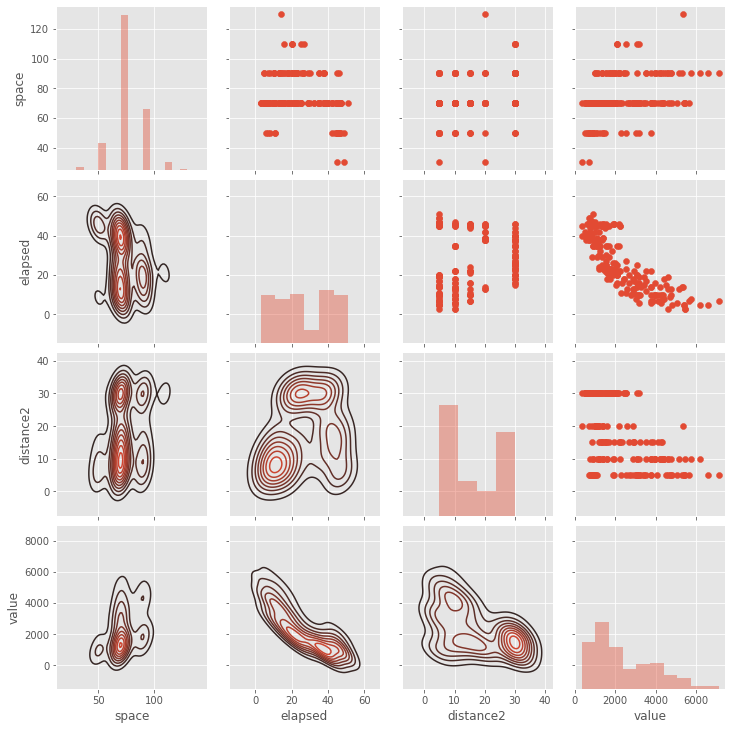

In [23]:
g = sns.PairGrid(df2)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.distplot, kde=False)
g = g.map_upper(plt.scatter)

In [26]:
model_code = """
data {
    int N;
    real elapsed[N];
    real dis[N];
    real space[N];
    real Y[N];
}

parameters {
    real d;
    real s;
    real e;
    real b;
    real<lower=0> sigma;
}

model {
    real mu;
    for (n in 1:N){
        mu = e * elapsed[n] + d * dis[n] + s * space[n] + b;
        Y[n] ~ normal(mu, sigma);
    }
}
"""

In [27]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_63d2380394613369084c022446c7b573 NOW.


In [28]:
stan_data = {"N": df.shape[0], "elapsed": df["elapsed"], "dis": df["distance2"], "space": df["space"], "Y": df["value"]}

In [29]:
fit = sm.sampling(data = stan_data, iter = 2000, warmup = 500, chains = 4, seed = 123)

In [30]:
fit

Inference for Stan model: anon_model_63d2380394613369084c022446c7b573.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d     -57.59    0.09   5.19 -67.97 -61.13 -57.54 -54.17 -47.36   3589    1.0
s      24.48    0.08    3.6  17.33  22.11  24.46  26.95   31.3   2210    1.0
e     -67.73    0.07   3.75 -74.93 -70.27 -67.78  -65.2 -60.25   3054    1.0
b     3311.0     6.4 298.53 2743.8 3106.9 3306.9 3508.2 3907.6   2178    1.0
sigma 636.81     0.5   33.3 575.37 613.78 635.34 657.63 705.78   4367    1.0
lp__   -1363    0.03   1.63  -1367  -1364  -1363  -1362  -1361   2303    1.0

Samples were drawn using NUTS at Mon Mar 23 00:16:52 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

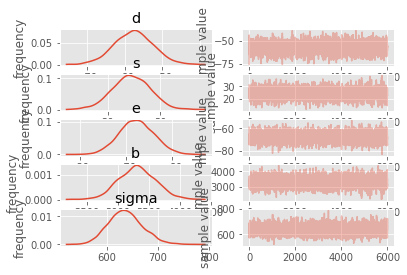

In [31]:
fig = fit.plot()